In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC

In [2]:
google_apps = pd.read_csv('Google Play Store Apps.zip')
google_reviews = pd.read_csv('google_app_reviews.csv')

In [3]:
google_apps.rename(columns={'App Id': 'app_id'}, inplace=True)

In [4]:
apps = google_apps.merge(google_reviews, on="app_id", how='inner')

In [5]:
apps.columns

Index(['App Name', 'app_id', 'Category', 'Rating', 'Rating Count', 'Installs',
       'Minimum Installs', 'Maximum Installs', 'Free', 'Price', 'Currency',
       'Size', 'Minimum Android', 'Developer Id', 'Developer Website',
       'Developer Email', 'Released', 'Last Updated', 'Content Rating',
       'Privacy Policy', 'Ad Supported', 'In App Purchases', 'Editors Choice',
       'Scraped Time', 'Unnamed: 0', 'user_name', 'score', 'content', 'likes',
       'polarity'],
      dtype='object')

In [6]:
apps = apps.groupby('app_id').mean()

In [7]:
apps = apps[apps['Rating'] > 0]

apps_copy = apps.copy()
apps_copy.dropna(inplace=True)

apps_copy['Rating Count'] = np.log(apps_copy['Rating Count'])
apps_copy['Rating'] = np.sqrt(apps_copy['Rating'])

In [8]:
apps_copy['likes'] = apps_copy['likes'] + 1
apps_copy['polarity_weight'] = apps_copy['likes'] * apps_copy['polarity']

(0.48086287902052977, 0.0)


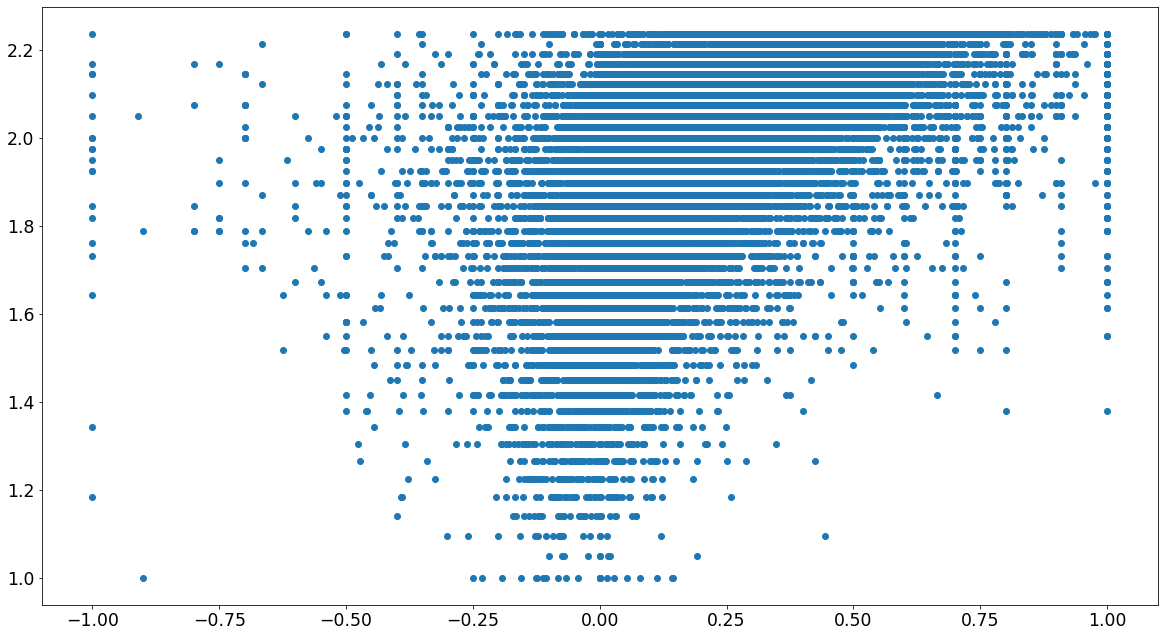

In [65]:
print(stats.pearsonr(apps_copy['Rating'], apps_copy['polarity']))
plt.figure(figsize=(20, 11))
plt.rcParams.update({'axes.labelsize': '88'})
plt.scatter(apps_copy['polarity'], apps_copy['Rating'])
plt.show()

In [17]:
apps_copy['Editors Choice'].unique()

array([0., 1.])

In [19]:
apps_copy.drop('Unnamed: 0', axis=1, inplace=True)

In [51]:
apps_copy['installs'] = (apps_copy['Minimum Installs'] + apps_copy['Maximum Installs']) / 2
apps_copy.drop(['Minimum Installs', 'Maximum Installs'], axis=1, inplace=True)

In [58]:
apps_copy.drop('score', axis=1, inplace=True)

In [59]:
features = ['Rating', 'polarity', 'Rating Count', 'installs', 'polarity_weight']

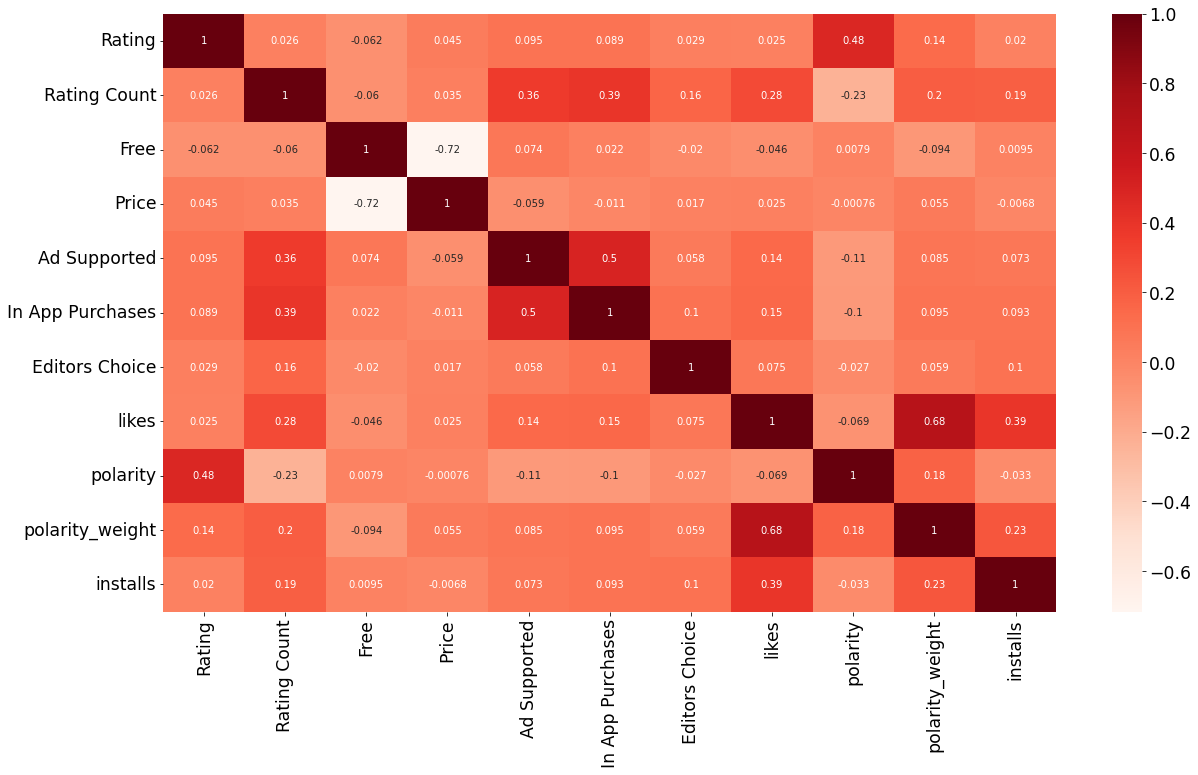

In [60]:
plt.rcParams.update({'xtick.labelsize': 'xx-large', 'ytick.labelsize': 'xx-large'})
plt.figure(figsize=(20, 11))
cor = apps_copy.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

# Select features and target

In [17]:
# apps_copy['Size'] = apps_copy['Size'][-1:]

In [40]:
X_train, X_test, y_train, y_test = train_test_split(apps_copy[features], apps_copy['Rating'], random_state = 1)

In [36]:
# plt.scatter(apps['Rating'], np.log(apps['installs']))

# Decision Tree 🌲

In [42]:
decision_tree = DecisionTreeRegressor(max_leaf_nodes=50, min_samples_split=100, min_samples_leaf=100, max_features=2, random_state = 1)
decision_tree.fit(X_train, y_train)

val_predictions = np.around(decision_tree.predict(X_test), decimals=2)
print("MAE: ",mean_absolute_error(y_test, val_predictions))
print("Decision Tree Score: ", decision_tree.score(X_test, y_test))

MAE:  0.04967460517428596
Decision Tree Score:  0.8744709306414502


# Random Forest 🌳🌳🌳🌳

In [43]:
forest_model = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(max_depth=15, n_estimators=100, min_samples_leaf=100, min_samples_split=500)
).fit(X_train, y_train)

preds = forest_model.predict(X_test)
print("MAE: ",mean_absolute_error(y_test, preds))
print("Random Forest Score: ", forest_model.score(X_test, y_test))

MAE:  0.002559621861068699
Random Forest Score:  0.9954979276139114


# K Nearest Neighbours

In [46]:
model = make_pipeline(
    StandardScaler(),
    KNeighborsRegressor(n_neighbors=40)
)
model.fit(X_train, y_train)
print("MAE: ",mean_absolute_error(y_test, model.predict(X_test)))
print("K Nearest Neighbours Score: ", model.score(X_test, y_test))

MAE:  0.01240384561687097
K Nearest Neighbours Score:  0.9897157519551402


# SVM

In [47]:
svm = make_pipeline(
    StandardScaler(), 
    SVR(C=2.0, epsilon=0.2, degree=3)
)
svm.fit(X_train, y_train)
print("MAE: ",mean_absolute_error(y_test, svm.predict(X_test)))

print("SVM Score: ", svm.score(X_test, y_test))

MAE:  0.061760966153173814
SVM Score:  0.8473455743600287


# Gradient Boosting Regressor

In [48]:
gbr = GradientBoostingRegressor(n_estimators=100, min_samples_leaf=10, max_depth=50)
gbr.fit(X_train, y_train)

print("MAE: ",mean_absolute_error(y_test, gbr.predict(X_test)))
print("GBR Score: ", gbr.score(X_test, y_test))

MAE:  7.623848594433062e-06
GBR Score:  0.9999996837505236


In [39]:
# from sklearn.svm import LinearSVR
# >>> from sklearn.pipeline import make_pipeline
# >>> from sklearn.preprocessing import StandardScaler
# >>> from sklearn.datasets import make_regression

# >>> regr = make_pipeline(StandardScaler(),
# ...                      LinearSVR(random_state=0, tol=1e-5, max_iter=5000))
# >>> regr.fit(X_train, y_train)
# regr.score(X_test, y_test)

1.0

In [49]:
# from sklearn.linear_model import LinearRegression
# from sklearn import linear_model

# reg = LinearRegression(fit_intercept=True).fit(X_train, y_train)
# reg.score(X_test, y_test)

1.0

In [50]:
clf = linear_model.BayesianRidge(n_iter=3, alpha_1=1, alpha_2=0.87)
clf.fit(X_train, y_train)
print("MAE: ",mean_absolute_error(y_test, clf.predict(X_test)))
clf.score(X_test, y_test)

MAE:  9.883461839059183e-08


0.9999999999995773